# UCI regression 

In [1]:
import jax
import optax
import numpy as np
import pandas as pd
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

import datagen
from functools import partial
from bayes_opt import BayesianOptimization
from jax.sharding import PositionalSharding
from rebayes_mini.methods import replay_sgd
from rebayes_mini.methods import gauss_filter as gfilter
from rebayes_mini.methods import robust_filter as rfilter
from rebayes_mini.methods import generalised_bayes_filter as gbfilter

In [2]:
devices = jax.devices()
sharding = PositionalSharding(devices)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%config InlineBackend.figure_format = "retina"

In [5]:
uci = datagen.UCIDatasets("./data")

dataset_name = "power-plant"
dataset_name = "yacht"

X_collection= []
y_collection = []
ix_clean_collection = []

n_runs = 48
v_error = 100
seed_init = 314
for i in range(n_runs):
    # data = uci.sample_one_sided_noisy_dataset(dataset_name, p_error=0.05, seed=seed_init + i, v_error=v_error)
    data = uci.sample_noisy_covariates(dataset_name, p_error=0.05, seed=seed_init + i, v_error=v_error)
    X = data["X"]
    y = data["y"]
    ix_clean = ~data["err_where"].astype(bool)
    
    X_collection.append(X)
    y_collection.append(y)
    ix_clean_collection.append(ix_clean)

In [6]:
X_collection = jnp.array(X_collection)
y_collection = jnp.array(y_collection)
mask_clean = np.array(ix_clean_collection).T

In [47]:
X_collection = jax.device_put(X_collection, sharding.reshape(-1, 1, 1))
y_collection = jax.device_put(y_collection, sharding.reshape(-1, 1))

In [48]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

# Setup

In [49]:
lr = 0.1
Q = 0.0

def callback_fn(bel, bel_pred, y, x, applyfn):
    yhat = applyfn(bel_pred.mean, x[None])
    return yhat

In [50]:
y, X = y_collection[0], X_collection[0]
ix_clean = ix_clean_collection[0]

In [51]:
Q = 0.0
observation_covariance = 1.0

In [52]:
key = jax.random.PRNGKey(314)
model = MLP()
params_init = model.init(key, X[:1])

## EKF

In [53]:
agent = gfilter.ExtendedKalmanFilter(
    lambda x: x,
    model.apply,
    dynamics_covariance=Q,
    observation_covariance=1.0 * jnp.eye(1),
)

bel_init = agent.init_bel(params_init, cov=lr)

callback = partial(callback_fn, applyfn=agent.vobs_fn)

In [54]:
%%time
callback = partial(callback_fn, applyfn=agent.vobs_fn)
scanfn = jax.vmap(agent.scan, in_axes=(None, 0, 0, None))
res = scanfn(bel_init, y_collection, X_collection, callback)

res = jax.block_until_ready(res)
state_final_collection, yhat_collection_ekf = res
yhat_collection_ekf = yhat_collection_ekf.squeeze()

CPU times: user 22.1 s, sys: 1.75 s, total: 23.8 s
Wall time: 16.4 s


In [55]:
err_collection_ekf = pd.DataFrame(np.power(y_collection - yhat_collection_ekf, 2).T)
summ_collection_ekf = err_collection_ekf.expanding(10).mean()

## WLF-IMQ

### Hparam choice

In [81]:
def filter_imqf(soft_threshold, log_lr):
    lr = np.exp(log_lr)
    agent = gbfilter.IMQFilter(
        model.apply, dynamics_covariance=Q,
        observation_covariance=observation_covariance,
        soft_threshold=soft_threshold
    )

    bel_init = agent.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent.link_fn)
    bel_imq, yhat_pp = agent.scan(bel_init, y, X, callback_fn=callback)
    out = (agent, bel_imq)
    return yhat_pp.squeeze(), out

def opt_step(soft_threshold, log_lr):
    res = -jnp.power(filter_imqf(soft_threshold, log_lr)[0] - y, 2)[ix_clean].mean()
    
    if np.isnan(res):
        res = -1e+6
    
    return res

In [ ]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "soft_threshold": (1e-6, 10),
        "log_lr": (-5, 0),
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=10)

|   iter    |  target   |  log_lr   | soft_t... |
-------------------------------------------------
| 12        | -0.03174  | 0.0       | 10.0      |


### Eval

In [ ]:
soft_threshold = bo.max["params"]["soft_threshold"]
lr = np.exp(bo.max["params"]["log_lr"])

agent = gbfilter.IMQFilter(
    model.apply,
    dynamics_covariance=0.0,
    observation_covariance=1.0,
    soft_threshold=soft_threshold
)

In [ ]:
%%time
bel_init = agent.init_bel(params_init, cov=lr)
callback = partial(callback_fn, applyfn=agent.link_fn)
_, yhat_collection_wlf = jax.vmap(agent.scan, in_axes=(None, 0, 0, None))(bel_init, y_collection, X_collection, callback)
yhat_collection_wlf = jax.block_until_ready(yhat_collection_wlf.squeeze())

In [ ]:
err_collection_wlf = pd.DataFrame(np.power(y_collection - yhat_collection_wlf, 2).T)

## IW-based EKF
(Agamenoni 2012)

### Hparam choice

In [61]:
def filter_rkf(noise_scaling, log_lr):
    lr = np.exp(log_lr)
    agent_rekf = rfilter.ExtendedRobustKalmanFilter(
        lambda x: x, model.apply, dynamics_covariance=Q,
        prior_observation_covariance=observation_covariance * jnp.eye(1),
        noise_scaling=noise_scaling,
        n_inner=1
    )
    
    bel_init = agent_rekf.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent_rekf.vobs_fn)
    bel_rekf, yhat_pp = agent_rekf.scan(bel_init, y, X, callback_fn=callback)
    out = (agent_rekf, bel_rekf)
    
    return yhat_pp.squeeze(), out

In [62]:
def opt_step(noise_scaling, log_lr):
    res = -jnp.power(filter_rkf(noise_scaling, log_lr)[0] - y, 2)[ix_clean].mean()
    if np.isnan(res):
        res = -1e+6
    
    return res

In [63]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "noise_scaling": (1e-6, 10),
        "log_lr": (-20, 0)
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=10)

|   iter    |  target   |  log_lr   | noise_... |
-------------------------------------------------
| 5         | -0.03733  | -1.765    | 2.608     |
| 11        | -0.03132  | 0.0       | 10.0      |
| 12        | -0.03048  | 0.0       | 1e-06     |
| 19        | -0.03028  | 0.0       | 0.3052    |
CPU times: user 3min 11s, sys: 2min 46s, total: 5min 58s
Wall time: 36.7 s


### Eval

In [64]:
noise_scaling = bo.max["params"]["noise_scaling"]
lr = np.exp(bo.max["params"]["log_lr"])

agent = rfilter.ExtendedRobustKalmanFilter(
    lambda x: x,
    model.apply,
    dynamics_covariance=0.0,
    prior_observation_covariance=1.0 * jnp.eye(1),
    n_inner=1,
    noise_scaling=noise_scaling,
)

In [65]:
bel_init = agent.init_bel(params_init, cov=lr)
callback = partial(callback_fn, applyfn=agent.vobs_fn)
_, yhat_collection_ann1 = jax.vmap(agent.scan, in_axes=(None, 0, 0, None))(bel_init, y_collection, X_collection, callback)
yhat_collection_ann1 = yhat_collection_ann1.squeeze()

In [66]:
err_collection_ann1 = pd.DataFrame(np.power(y_collection - yhat_collection_ann1, 2).T)

## Mahalanobis-based EKF
(Ting 2007)

### Hparam section

In [67]:
def filter_mah_ekf(threshold, log_lr):
    lr = np.exp(log_lr)
    agent_mekf = rfilter.ExtendedThresholdedKalmanFilter(
        lambda x: x, model.apply,
        dynamics_covariance=Q,
        observation_covariance=observation_covariance * jnp.eye(1),
        threshold=threshold
    )
    
    bel_init = agent_mekf.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent_mekf.vobs_fn)
    
    bel_mekf, yhat_pp = agent_mekf.scan(bel_init, y, X, callback_fn=callback)
    out = (agent_mekf, bel_mekf)
    return yhat_pp.squeeze(), out

In [68]:
%%time
bo = BayesianOptimization(
    lambda threshold, log_lr: -jnp.power(filter_mah_ekf(threshold, log_lr)[0] - y, 2)[ix_clean].mean(),
    pbounds={
        "threshold": (1e-6, 20),
        "log_lr": (-20, 0)
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=10)

|   iter    |  target   |  log_lr   | threshold |
-------------------------------------------------
| 3         | -0.03635  | -1.64     | 16.55     |
| 11        | -0.02989  | 0.0       | 20.0      |
| 12        | -0.02986  | 0.0       | 8.756     |
| 14        | -0.02985  | 0.0       | 14.71     |
CPU times: user 7min 11s, sys: 3min 1s, total: 10min 13s
Wall time: 1min 17s


### Eval

In [69]:
threshold = bo.max["params"]["threshold"]
lr = np.exp(bo.max["params"]["log_lr"])

agent = rfilter.ExtendedThresholdedKalmanFilter(
    lambda x: x,
    model.apply,
    dynamics_covariance=0.0,
    observation_covariance=1.0 * jnp.eye(1),
    threshold=threshold,
)

In [70]:
%%time
bel_init = agent.init_bel(params_init, cov=lr)
bel_init = jax.device_put(bel_init, sharding.replicate(0))
callback = partial(callback_fn, applyfn=agent.vobs_fn)
scanfn = jax.jit(jax.vmap(agent.scan, in_axes=(None, 0, 0, None)), static_argnames=("callback_fn",))

_, yhat_collection_mekf = scanfn(bel_init, y_collection, X_collection, callback)
yhat_collection_mekf = jax.block_until_ready(yhat_collection_mekf)
yhat_collection_mekf = yhat_collection_mekf.squeeze()

CPU times: user 21.7 s, sys: 1 s, total: 22.7 s
Wall time: 16 s


In [71]:
err_collection_mekf = pd.DataFrame(np.power(y_collection - yhat_collection_mekf, 2).T)

## Online SGD

In [72]:
def lossfn(params, counter, x, y, applyfn):
    yhat = applyfn(params, x)
    return jnp.sum(counter * (y - yhat) ** 2) / counter.sum()

In [73]:
agent = replay_sgd.FifoSGD(
    model.apply,
    lossfn,
    optax.adam(0.1),
    buffer_size=1,
    dim_features=X.shape[-1],
    dim_output=1,
    n_inner=1
)

callback = partial(callback_fn, applyfn=model.apply)

bel_init = agent.init_bel(params_init)
state_final, yhat = agent.scan(bel_init, y, X, callback)
yhat = yhat.squeeze()

errs = (y - yhat)[ix_clean]
jnp.sqrt(jnp.power(errs, 2).mean())

Array(2.2119625, dtype=float32)

In [74]:
%%time
_, yhat_collection_ogd = jax.vmap(agent.scan, in_axes=(None, 0, 0, None))(bel_init, y_collection, X_collection, callback)
yhat_collection_ogd = jax.block_until_ready(yhat_collection_ogd)
yhat_collection_ogd = yhat_collection_ogd.squeeze()

CPU times: user 872 ms, sys: 68.9 ms, total: 941 ms
Wall time: 666 ms


In [75]:
err_collection_ogd  = pd.DataFrame(np.power(y_collection - yhat_collection_ogd, 2).T)

# Results

In [76]:
import seaborn as sns

In [77]:
pd.set_option("display.float_format", lambda x: format(x, "0.4f"))

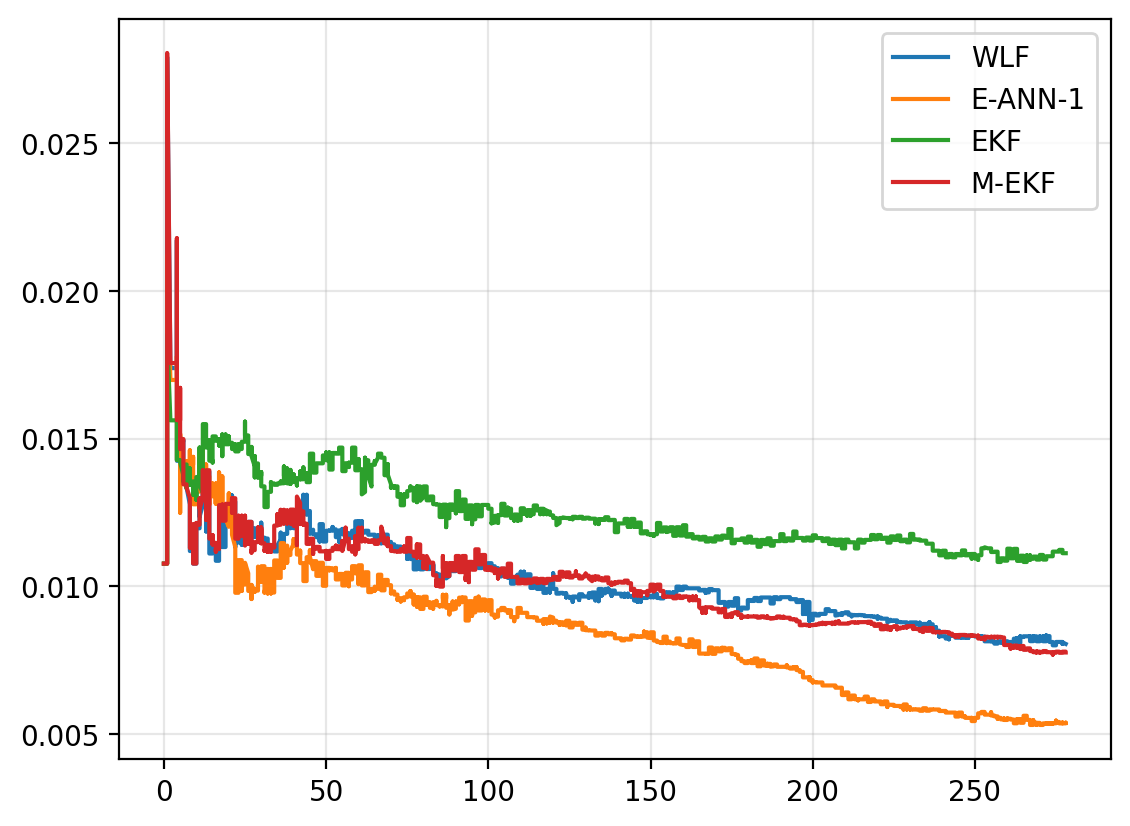

In [78]:
err_collection_wlf[mask_clean].expanding().median().median(axis=1).plot(label="WLF")
err_collection_ann1[mask_clean].expanding().median().median(axis=1).plot(label="E-ANN-1")
err_collection_ekf[mask_clean].expanding().median().median(axis=1).plot(label="EKF")
err_collection_mekf[mask_clean].expanding().median().median(axis=1).plot(label="M-EKF")
# plt.yscale("log")
plt.legend()
plt.grid(alpha=0.3)

In [79]:
df_results = pd.DataFrame({
    "WLF-IMQ": err_collection_wlf.mul(mask_clean)[10:].sum(axis=0) / mask_clean[10:].sum(axis=0),
    "EKF": err_collection_ekf.mul(mask_clean)[10:].sum(axis=0) / mask_clean[10:].sum(axis=0),
    "OGD": err_collection_ogd.mul(mask_clean)[10:].sum(axis=0) / mask_clean[10:].sum(axis=0),
    "M-EKF": err_collection_mekf.mul(mask_clean)[10:].sum(axis=0) / mask_clean[10:].sum(axis=0),
    "E-ANN-1": err_collection_ann1.mul(mask_clean)[10:].sum(axis=0) / mask_clean[10:].sum(axis=0),
})

df_results.describe()

,WLF-IMQ,EKF,OGD,M-EKF,E-ANN-1
count,48.0000,48.0000,48.0000,48.0000,48.0000
mean,0.0293,0.0430,45.3124,0.0262,0.0262
std,0.0216,0.0360,51.0726,0.0154,0.0201
min,0.0167,0.0233,2.1930,0.0146,0.0141
25%,0.0208,0.0294,11.3512,0.0201,0.0186
50%,0.0235,0.0341,24.9400,0.0220,0.0210
75%,0.0285,0.0402,58.4954,0.0256,0.0255
max,0.1599,0.2631,275.2191,0.1153,0.1485


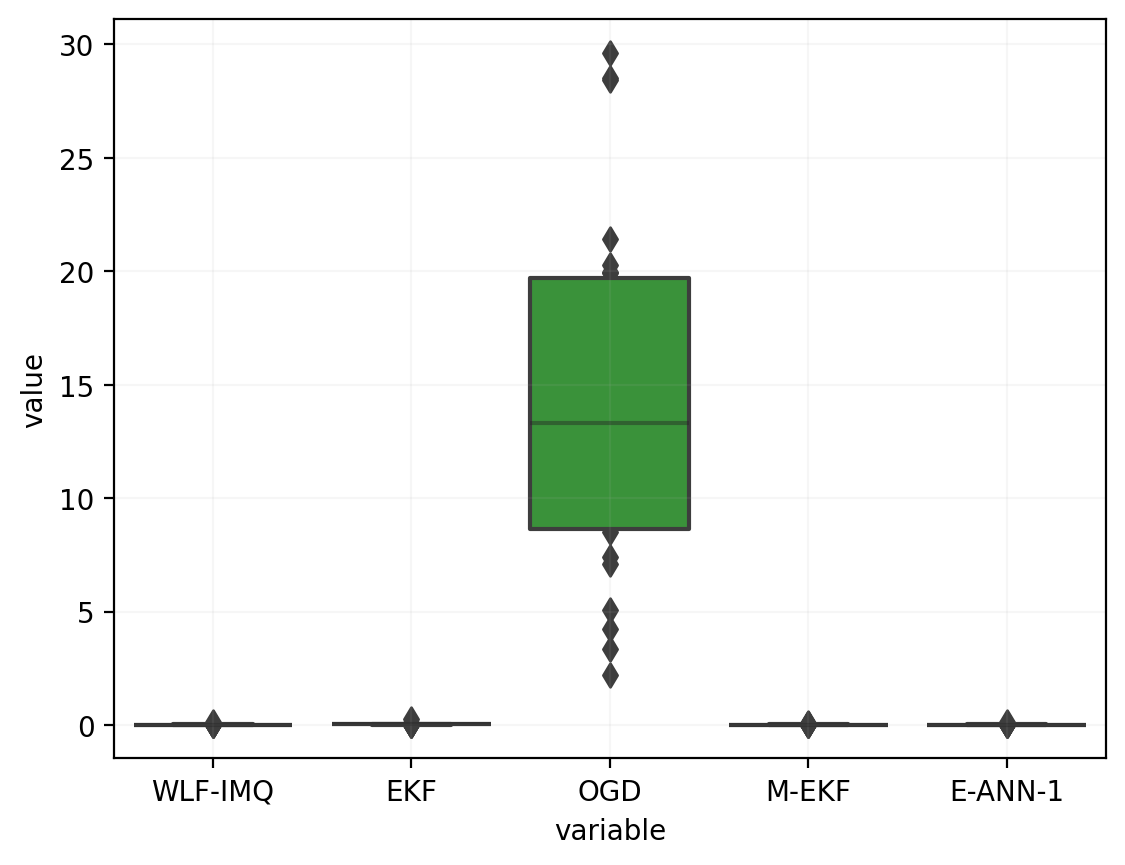

In [80]:
sns.boxenplot(
    x="variable",
    y="value",
    data=df_results.melt().query("value < 30"),
)
plt.grid(alpha=0.1)